In [84]:
# TODO WE NEED TO NORMALIZE THE INPUTS YOU DUMMY (just find the max of all of the stock market data in the datasets and divide the stock value by that)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, random
pd.options.mode.chained_assignment = None

In [85]:
# globals
NUM_EPOCHS = 1000
BATCH_SIZE = 100
LEARNING_RATE = 0.001
TRAINING_SPLIT = 0.8
DROPOUT_RATE = 0.2
CURRENT_DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

WINDOW_SIZE = 40
HIDDEN_SIZE = 1
NUM_LAYERS = 10
DATA_TO_PREDICT = ["Close", "Open", "High", "Low"]

DATASET_PATH = "StockMarketDataset/Stocks"
PERCENT_DATASET_TO_USE = 0.01
ONLY_USE_ONE_STOCK = True

In [86]:
# load the dataset into RAM
class SingleStockMarketDataset(Dataset):
    def __init__(self, stock_market_data_path, data_to_predict, window_size, device):
        """Accepts the stock market data as a csv"""
        df = pd.read_csv(stock_market_data_path, engine="pyarrow")
        self.data = df[data_to_predict].values

        # transform to windowed data so we can perform time series analysis
        self.windowed_data = torch.tensor(self._get_windowed_data(self.data, window_size), dtype=torch.float32).to(device)
        self.dataset_length = len(self.windowed_data)
        self.data_max = self.data.max()
        print(self.data_max)

    def _get_windowed_data(self, input_data: np.ndarray, window_size: int):
        """
        gets a 3d numpy array with the following dimensions (dataset index, time index, input index)
        
        - The dataset index is just the data's position in the database
        - The time index represents how recent the input is. Index 0 is today's prices, Index 1 is yesterday's prices and so on. 
            The length of this is the window size
        - The input index just indexes through the input length. This can represent the Open, High, Low, and Close prices.
            This is controlled by the data_to_predict
        """
        
        input_data = input_data.tolist()
        windowed_data = input_data[window_size-1:]
        for row in range(len(windowed_data)):
            windowed_data[row] = [input_data[row + window_size - lookback_count - 1] for lookback_count in range(window_size)]

        return np.array(windowed_data)
    
    
    def __len__(self):
        return self.dataset_length
    
    def __getitem__(self, index):
        # we want to use the past data to try and predict today's stock prices
        label = self.windowed_data[index][0]      # the first "time index" which we are grabbing here is today's stock price
        input = self.windowed_data[index][1:]       # all of the other "time indices" are the stock prices for the past
        
        return input/ self.data_max, label/ self.data_max

class MultiStockMarketDataset(Dataset):
    """Creates a bunch of datasets for each stock and compiles them together"""
    
    def __init__(self, dataset_path, data_to_predict, window_size, device):
        self.total_length = 0
        self.stock_market_dataset = []
        
        print(len(os.listdir(dataset_path)))
        for index, stock_market_data_file in enumerate(os.listdir(dataset_path)):
            # reject a certain percent of the dataset
            if random.random() > PERCENT_DATASET_TO_USE: continue
            
            stock_market_data_path = os.path.join(dataset_path, stock_market_data_file)
            new_single_dataset = SingleStockMarketDataset(stock_market_data_path, data_to_predict, window_size, device)
            self.stock_market_dataset.append(new_single_dataset)
            self.total_length += new_single_dataset.__len__()
            
            if ONLY_USE_ONE_STOCK: return
    
    def __len__(self):
        return self.total_length
    
    def find_data_point_for_index(self, datapoint_index):
        """returns (SingleStockMarketDataset, index inside that dataset to find the data in)"""
        for dataset_index in range(len(self.stock_market_dataset)):
            dataset_length = self.stock_market_dataset[dataset_index].__len__()
            
            if datapoint_index - dataset_length < 0:
                return self.stock_market_dataset[dataset_index], datapoint_index
            
            else:
                datapoint_index -= self.stock_market_dataset[dataset_index].__len__()
        
        raise IndexError("Index out of bounds")
                
            
            
    def __getitem__(self, index):
        single_stock_market_dataset, index = self.find_data_point_for_index(index)
        return single_stock_market_dataset.__getitem__(index)
                
                
        
    
stock_market_dataset = MultiStockMarketDataset(DATASET_PATH, DATA_TO_PREDICT, WINDOW_SIZE, CURRENT_DEVICE)
stock_market_train_dataset, stock_market_test_dataset = random_split(stock_market_dataset, [TRAINING_SPLIT, 1 - TRAINING_SPLIT])

train_dataloader = DataLoader(stock_market_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(stock_market_test_dataset, batch_size=BATCH_SIZE, shuffle=True)


7163
25.5


In [87]:
class StockMarketPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout, device):
        super(StockMarketPredictor, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.device = device
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout, device=self.device)
        self.fully_connected_layer = nn.Linear(hidden_size, output_size, device=self.device)
        
        
    def forward(self, x: torch.Tensor):
        initial_hidden_state = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        initial_cell_state = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        
        x, (hidden_state, cell_state) = self.lstm(x, (initial_hidden_state, initial_cell_state))
        x = x[:, -1, :]
        x = self.fully_connected_layer(x)
        return x
    
stock_market_predictor = StockMarketPredictor(len(DATA_TO_PREDICT), HIDDEN_SIZE, NUM_LAYERS, len(DATA_TO_PREDICT), DROPOUT_RATE, CURRENT_DEVICE)
loss_function = nn.MSELoss()
optimizer = optim.Adam(stock_market_predictor.parameters(), lr=LEARNING_RATE)

[array(1.2169232, dtype=float32), array(1.2140707, dtype=float32), array(1.2100669, dtype=float32), array(1.2090617, dtype=float32), array(1.2049555, dtype=float32), array(1.2027906, dtype=float32), array(1.2003913, dtype=float32), array(1.197668, dtype=float32), array(1.1951329, dtype=float32), array(1.1915799, dtype=float32), array(1.1880922, dtype=float32), array(1.1862857, dtype=float32), array(1.1836535, dtype=float32), array(1.1799003, dtype=float32), array(1.1804823, dtype=float32), array(1.1756129, dtype=float32), array(1.1715856, dtype=float32), array(1.1694556, dtype=float32), array(1.1663905, dtype=float32), array(1.1628135, dtype=float32), array(1.1618924, dtype=float32), array(1.1575221, dtype=float32), array(1.1555778, dtype=float32), array(1.1515393, dtype=float32), array(1.1490523, dtype=float32), array(1.1471558, dtype=float32), array(1.1441517, dtype=float32), array(1.1409345, dtype=float32), array(1.1390547, dtype=float32), array(1.135648, dtype=float32), array(1.132

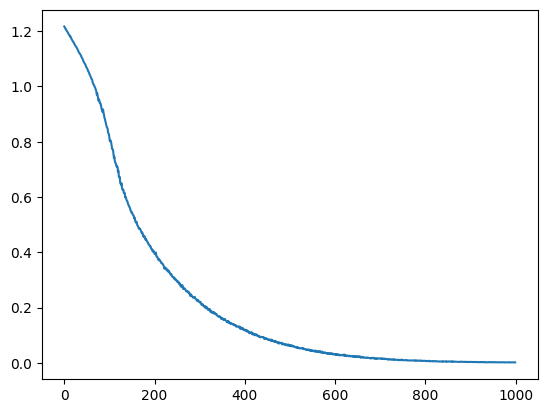

In [88]:
losses = []
for epoch in range(NUM_EPOCHS):
    for x_batch, y_batch in train_dataloader:
        optimizer.zero_grad()
        
        predictions_batch = stock_market_predictor(x_batch)
        # print(predictions_batch)
        
        # print(predictions_batch.shape)
        # print(y_batch.shape)
        loss = loss_function(predictions_batch, y_batch)
        
        loss.backward()
        optimizer.step()
        
        losses.append(loss.cpu().detach().numpy())
        
plt.plot(losses)
print(losses)

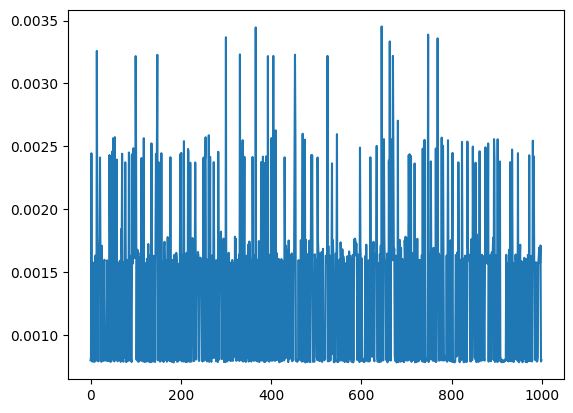

In [89]:
# test the model on data it has never seen before
test_losses = []
for test_epoch in range(NUM_EPOCHS):
    for x_batch, y_batch in test_dataloader:
        predictions_batch = stock_market_predictor(x_batch)
        loss = loss_function(predictions_batch, y_batch)
        test_losses.append(loss.cpu().detach().numpy())

plt.plot(test_losses)
        